In [4]:
# The ultimate target feature: time from one stop to another

# Imports
import pandas as pd
import numpy as np
from datetime import date, datetime
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from statsmodels.formula.api import ols

# Read csv file into a dataframe.
df = pd.read_csv('beta25.csv')

# 1.0 Data Cleaning 

## 1.1 Rename column names

In [5]:
df = df.rename(columns={'Timeframe': 'Start_date'})

## 1.2 Dropping duplicates

In [6]:
df=df.drop_duplicates(keep='first')

## 1.3 Dropping constant columns or columns with missing data

In [7]:
df = df.drop('Direction', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Congestion', axis=1)
df[df.Journey_Pattern_ID == 'null']
#df = df[df['Journey_Pattern_ID'] != '00040002']
#df = df[df['Journey_Pattern_ID'] != '00041002']

ValueError: labels ['Congestion'] not contained in axis

## 1.4 Remove rows where bus is not at stop

In [ ]:
df = df.loc[(df != 0).all(axis=1), :]

## 1.5 Group to normalise time & remove rows where bus idle at stop

In [ ]:
# Create empty column which will hold normalised time
df['normal_time'] = 0

In [ ]:
# Create empty column which will hold the stop order
df['stop_order'] = 0

In [ ]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [ ]:
def normalize_time(df):
    """Normalise the time for each journey"""
    for i in range(df['Timestamp'].size):
        df['normal_time'].values[i] = (df['Timestamp'].values[i] - df['Timestamp'].values[0]) / 1000000
        
    return df

In [ ]:
norm_gb = grouped_df.apply(normalize_time)

In [ ]:
grouped_df = norm_gb.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [ ]:
def remove_idle_at_stop(df):
    df = df.drop_duplicates(subset='Stop_ID', keep='first')
    
    return df

In [ ]:
norm_gb = grouped_df.apply(remove_idle_at_stop)

In [ ]:
grouped_df = norm_gb.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [ ]:
def route_order(df):
    for i in range(df['Timestamp'].size):
        df['stop_order'].values[i] = i+1
    
    return df

In [ ]:
df = grouped_df.apply(route_order)

In [ ]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [ ]:
#removed crystallising end stop as take that out later on - for flexibility to run checks beforehand
#have to add stops near the beginning as just the first stop is not capturing all journies, drivers must not be setting the 
#vehicle journey ID before starting off
def stop_start_only(df):
    if ( (df['Stop_ID'][0] == '7330') | (df['Stop_ID'][0] == '7113') | (df['Stop_ID'][0] == '324') | (df['Stop_ID'][0] == '327') | (df['Stop_ID'][0] == '2051')| (df['Stop_ID'][0] == '6086')):
                                                                        
        df['full_trip'] = 1
    return df

In [ ]:
df = grouped_df.apply(stop_start_only)

In [ ]:
df = df.loc[df['full_trip'] == 1]

## 1.6 Add new features

In [9]:
df["Time"] = pd.to_datetime(df['Timestamp']*1000, unit="ns")

In [10]:
df['IsWeekend'] = np.where((df['Time'].dt.dayofweek > 5), 1, 0)

In [11]:
df['HourOfDay'] = df['Time'].dt.hour

In [12]:
df['MinsOfHour'] = df['Time'].dt.minute

In [13]:
df['DayOfWeek'] = df['Time'].dt.dayofweek

In [14]:
df['IsEveningTime'] = np.where((df['Time'].dt.hour > 17), 1, 0)

In [15]:
df['Direction_north'] = np.where((df['Journey_Pattern_ID'] == '00041001'), 1,0)

/Users/katerooney/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [16]:
df['IsPeakTime'] = np.where(((df['HourOfDay'] >= 7) & (df['HourOfDay'] <= 10)) | ((df['HourOfDay'] >= 16) & (df['HourOfDay'] <= 19)), 1, 0)

In [17]:
df['RDS_Event'] = np.where((df['Time'].dt.date == datetime(2013, 1, 27).date()), 1, 0)

In [18]:
df['BankHoliday'] = np.where((df['Time'].dt.date == datetime(2013, 1, 1).date()), 1, 0)

In [19]:
df['SchoolHoliday'] = np.where((df['Time'].dt.date == datetime(2012, 11, 1).date()) | (

df['Time'].dt.date == datetime(2012, 11, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 1).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 3).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 4).date()), 1, 0)

# 2.0 Merge Datasets

## 2.1 Merge bus stop info

In [ ]:
df_bus_stop = pd.read_csv('csv_data/busstopinfo.csv', encoding='latin-1')

In [ ]:
df_bus_stop = df_bus_stop.rename(columns={'stopid': 'Stop_ID'})
df_bus_stop = df_bus_stop.rename(columns={'fullname': 'Stop_name'})

In [ ]:
df_bus_stop = df_bus_stop[['Stop_ID', 'Stop_name']]

In [ ]:
df = pd.merge(df, df_bus_stop, on=['Stop_ID'])

In [ ]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [ ]:
grouped_df.get_group((4558, '2013-01-03'))

In [ ]:
grouped_df.get_group((4542, '2013-01-15'))

In [ ]:
df.shape

## 2.2 Merge weather data

In [20]:
df_weather = pd.read_csv('csv_data/weather_data.csv', encoding='latin-1')

In [21]:
df_weather = df_weather.rename(columns={'Rainfall (Yes or No)': 'Rain'})
df_weather = df_weather.rename(columns={'Temperature C': 'Temperature'})
df_weather = df_weather.rename(columns={'Relative Humidity (%)': 'Humidity'})
df_weather = df_weather.rename(columns={'Over 1mm Rain?': 'Heavy_rain'})
df_weather = df_weather.rename(columns={'Precipitation (mm)': 'Precipitation'})
df_weather = df_weather.rename(columns={'Date': 'Time'})
df_weather['Time'] = pd.to_datetime(df_weather['Time'])
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df_weather['HourOfDay'] = df_weather['Time'].dt.hour

In [22]:
df.sort_values(['Time'], ascending=[True], inplace=True)
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df =  pd.merge_asof(df, df_weather, on='Time')

In [23]:
#code from here: https://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

drop_y(df)
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Lon', 'Lat', 'Vehicle_ID', 'Stop_ID', 'At_Stop',
       'Stops_Made', 'Time', 'Day_Of_Week', 'Hour_Of_Day', 'Min_Of_Hour',
       'Min_Of_Hour30', 'Min_Of_Hour15', 'Min_Of_Hour45', 'Time_Bin_Start',
       'End_Time', 'Start_Time', 'Journey_Time_Dirty', 'Journey_Time',
       'Scheduled_Time_OP', 'Mins_Late', 'Late', 'Time_Traveling',
       'Stop_Sequence', 'Max_Stop_Sequence', 'Speed', 'Start_Stop', 'End_Stop',
       'Stops_To_Travel', 'Time_To_Travel_Dirty', 'Time_To_Travel',
       'Scheduled_Speed_Per_Stop', 'time_bins', 'IsWeekend', 'HourOfDay_x',
       'MinsOfHour', 'DayOfWeek', 'IsEveningTime', 'IsPeakTime', 'RDS_Event',
       'BankHoliday', 'SchoolHoliday', 'Precipitation', 'Temperature',
       'Vapour Pressure (hPa)                ', 'Humidity',
       'Mean Sea Level Pressure (hPa)', 'Rain', 'Heavy_rain'],
      dtype='object')

In [24]:
def rename_x(df):
    for col in df:
        if col.endswith('_x'):
            df.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(df)

In [25]:
df['Proper_rain'] = np.where(((df['Precipitation'] < 2.3) & (df['Precipitation'] > 1.7) & (df['IsPeakTime']==1)), 1, 0)

# 3.0 Remove and categories columns

## 3.1 Drop missing values

In [ ]:
df = df[df['Journey_Pattern_ID'] != 'null']

## 3.2 Categorise to continuous and categorical

In [ ]:
df['IsWeekend'] = df['IsWeekend'].astype('category')
df['HourOfDay'] = df['HourOfDay'].astype('category')
df['IsEveningTime'] = df['IsEveningTime'].astype('category')
df['SchoolHoliday'] = df['SchoolHoliday'].astype('category')
df['IsPeakTime'] = df['IsPeakTime'].astype('category')
df['Operator'] = df['Operator'].astype('category')
df['At_Stop'] = df['At_Stop'].astype('category')
categorical_columns = df.select_dtypes(['category']).columns

In [ ]:
continuous_columns = df.select_dtypes(['int64', 'float64']).columns

## 3.3 Drop columns no longer needed

In [ ]:
df = df.drop('Lat', axis=1)
df = df.drop('Lon', axis=1)
df = df.drop('Block_ID', axis=1)
df = df.drop('Operator', axis=1)

## 3.4 Create time to destination feature

In [ ]:
df['end_time'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Timestamp'].transform(max)

In [ ]:
df['start_time'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Timestamp'].transform(min)

In [ ]:
df['time_diff_to_destination'] = df['end_time'] - df['Timestamp']
df.shape

In [ ]:
df_count = df.loc[(df.DayOfWeek == 0)]
df_count.shape

In [ ]:
df['late'] = ((df['end_time'] - df['start_time']) )
df['time_travelling'] = ((df['Timestamp'] - df['start_time']) )
df['journey_time'] = pd.to_timedelta(df['late']*1000, unit="ns").astype('timedelta64[m]')
df['mins_late'] = ((df['journey_time'].astype(int) - 60))
df['late'] = np.where((df['mins_late'] > 1), 1, 0)
df = df.loc[ (df.Stop_ID == '7226') | (df.Stop_ID == '322') | (df.Stop_ID == '332') | (df.Stop_ID == '6085')| (df.Stop_ID == '2026')]
df['speed']= ((df['time_travelling'].astype('float64') / df['stop_order'].astype('float64')) )

In [ ]:
df_count = df.loc[(df.DayOfWeek == 0)]
df_count.shape

In [ ]:
#df = df.loc[(df.Stop_ID == '7113') | (df.Stop_ID == '7330') | (df.Stop_ID == '7226') | (df.Stop_ID == '322')]

In [ ]:
df.columns

In [ ]:
#grouped_df.get_group((4601, '2013-01-29'))

In [ ]:
df['Vehicle_Journey_ID'] = pd.to_numeric(df['Vehicle_Journey_ID'], errors='coerce')

#    # Extra plots

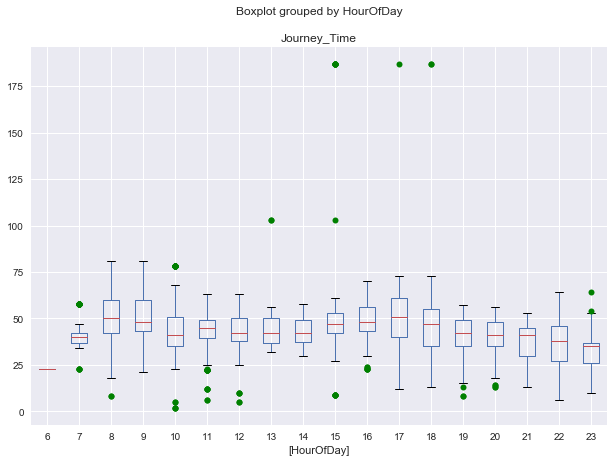

In [28]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Journey_Time'], by=['HourOfDay'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Temp_to_late.pdf')

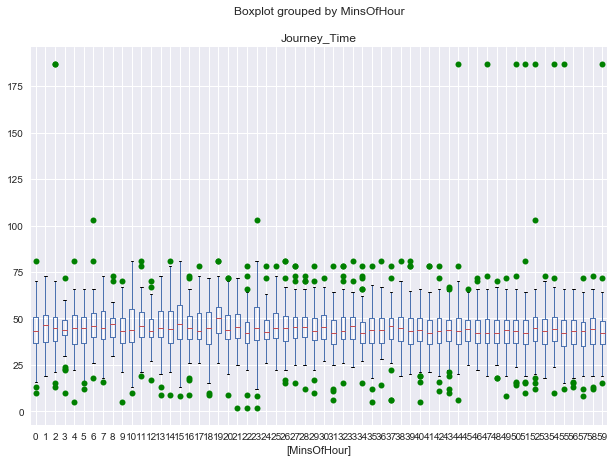

In [29]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Journey_Time'], by=['MinsOfHour'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Mins_to_journey_time.pdf')

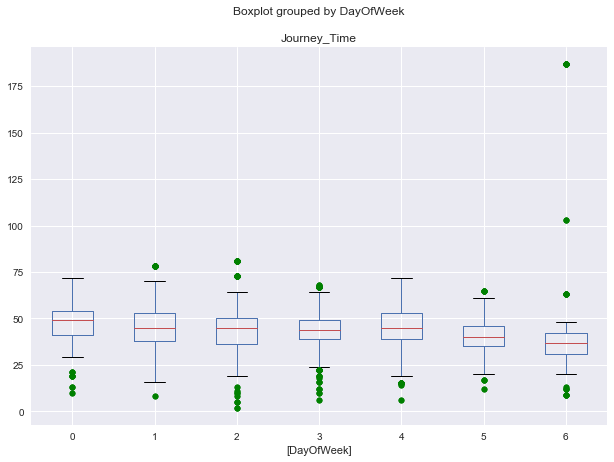

In [30]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Journey_Time'], by=['DayOfWeek'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_DayOfWeek_chart.pdf')

What is this telling us that there are absolutely no outliers here?

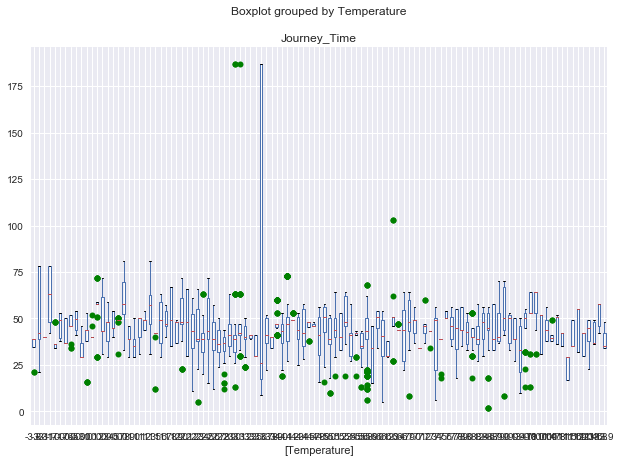

In [34]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Journey_Time'], by=['Temperature'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_late.pdf')

In [ ]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['Direction_north'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Journey_Pattern_ID_to_late.pdf')

Represents direction

In [ ]:
df.Vehicle_Journey_ID.value_counts().plot(kind='bar')

More buses running certain vehicle journey IDs

In [ ]:
df.Vehicle_Journey_ID.unique()

In [ ]:
import statsmodels.formula.api as sm

# Train all continuous features.
check1 = sm.ols(formula="journey_time ~ Proper_rain", data=df).fit()
# Print the weights learned for each feature.
print(check1.summary())

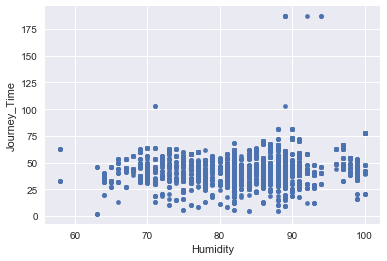

In [35]:
df.plot(kind = 'scatter', y='Journey_Time', x='Humidity')

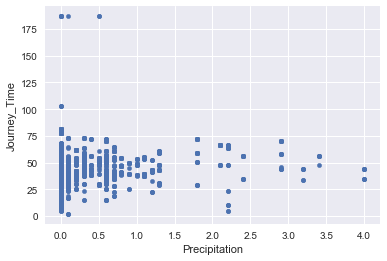

In [36]:
df.plot(kind = 'scatter', y='Journey_Time', x='Precipitation')

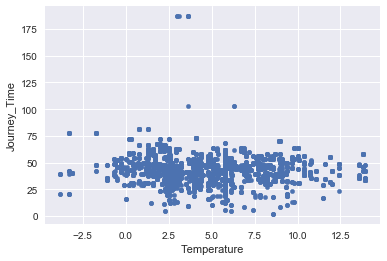

In [37]:
df.plot(kind = 'scatter', y='Journey_Time', x='Temperature')

In [ ]:
df_check_journey_ID = df.loc[df['mins_late'] > 1]
df_check_journey_ID = df_check_journey_ID[['late','Vehicle_Journey_ID']]
df_check_journey_ID.Vehicle_Journey_ID.unique()

If Vehicle Journey ID starts with 9 it is never late

In [ ]:
df_check_2 = df.loc[(df.Vehicle_Journey_ID == 4585) & (df.Stop_ID == '7226')]
df_check_2.Time

(0, 100)

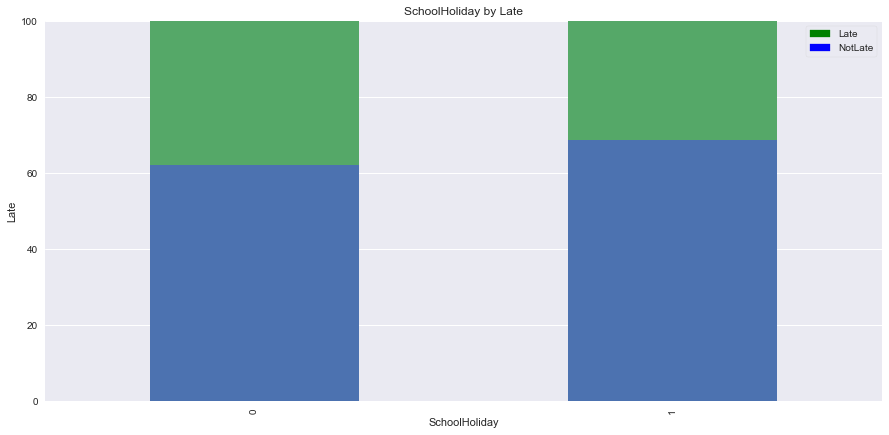

In [39]:
SchoolHoliday = pd.unique(df.SchoolHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.SchoolHoliday == p].count()['Late']
    index_list = df[df['SchoolHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','SchoolHoliday','Late']].groupby(['SchoolHoliday','Late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="SchoolHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("SchoolHoliday")
my_plot.set_ylabel("Late")
my_plot.set_ylim([0,100])

In [ ]:
BankHoliday = pd.unique(df.BankHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in BankHoliday:
    count = 1 / df[df.BankHoliday == p].count()['late']
    index_list = df[df['BankHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','BankHoliday','late']].groupby(['BankHoliday','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="BankHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("BankHoliday")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

In [ ]:
IsWeekend = pd.unique(df.IsWeekend.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.IsWeekend == p].count()['late']
    index_list = df[df['IsWeekend'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','IsWeekend','late']].groupby(['IsWeekend','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="IsWeekend by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("IsWeekend")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

In [ ]:
# Group dataframe  and sum percent
group = df[['percent','DayOfWeek','late']].groupby(['DayOfWeek','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="DayOfWeek by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("DayOfWeek")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

In [ ]:
# Group dataframe and sum percent
group = df[['percent','HourOfDay','late']].groupby(['HourOfDay','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="HourOfDay by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("HourOfDay")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

In [ ]:
bins=[10,20,30,40,50,60,70,80,90,100,110]

In [ ]:
df['time_bins'] = np.digitize(df.journey_time.values, bins=bins)
df.time_bins.unique()

In [ ]:
df.shape

In [ ]:
df_check_journey_time = df.loc[df['journey_time'] < 20]
df_check_journey_time = df_check_journey_time[['journey_time','Vehicle_Journey_ID', 'Time', 'stop_order', 'Stop_ID', 'end_time']]
df_check_journey_time.sort_values(['journey_time'], ascending=[True])

# 4.0 Save DF to be used in Model Analysis

In [40]:
# Save cleaned dataframe to new CSV file
df.to_csv('csv_data/bus_route4_clean.csv', index=False)

---

In [ ]:
df_train = df[:130000]

In [ ]:
df_test = df[130000:]

df_group = df.groupby(['Vehicle_Journey_ID', 'Start_date'])